Exercises:

`1. Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?`

It did better (as expected). Table description:
- training loss,
- no regularisation/smoothing,
- 200 epochs for 2/3-gram models,
- 600 epochs for 4-gram (probably needs better hyperparameters).

| model type    | bigram loss | trigram loss | 4-gram loss  |
|---------------|-------------|--------------|--------------|
| counting      |       2.454 |        1.942 |        1.471 |
| backprop (nn) |       2.460 |        2.029 |        1.780 |

</br>

`2. Split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?`

200 epochs training 

| model            | train loss | val loss | test loss |
|------------------|------------|----------|-----------|
| bigram nn        |      2.459 |    2.464 |     2.466 |
| trigram (wd=0.0) |      1.992 |    2.222 |     2.237 |
| trigram (wd=0.1) |      1.977 |    2.189 |     2.233 |

For bigram model train loss is a little bit better than val and test losses.</br>
For trigram model the difference is significant - val and test loss ~10% higher than train loss. 

`3. Use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?`

Added results in the ex. 2 table. Slight improvement in all 3 losses. Finally test_loss is 2.223.

`4. We saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?`

Done that on the trigram (ngram) model.

`5. Look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?`

Done. Cross entropy works for multilabel classification, or some non 0/1 labels (eg. after smoothing).`

`6. Meta-exercise! Think of a fun/interesting exercise and complete it.`

Created generalized version of ngram models (counts and nn) for any arbitrary n. Trained 4-gram models (counting and nn).

In [65]:
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm

## Data

In [2]:
data_fpath = './data/names.txt'

In [3]:
with open(data_fpath, 'r') as f:
    words = f.read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
len(words)

32033

In [5]:
word_lens = [len(word) for word in words]
print(f'min len: {min(word_lens)}; max len: {max(word_lens)}')

min len: 2; max len: 15


In [6]:
SEP_TOK = '.'

In [8]:
n = 3  # this indicates the n in n-grams

In [9]:
ngrams_dict = {}
for word in words:
    chars = [SEP_TOK]*(n-1) + list(word) + [SEP_TOK]*(n-1)
    ngram_chars = [chars[i:] for i in range(n)]
    for ngram in zip(*ngram_chars):
        ngrams_dict[ngram] = ngrams_dict.get(ngram, 0) + 1
ngrams_dict = sorted(ngrams_dict.items(), key=lambda kv: kv[1], reverse=True)
ngrams_dict[:10]

[(('n', '.', '.'), 6763),
 (('a', '.', '.'), 6640),
 (('.', '.', 'a'), 4410),
 (('e', '.', '.'), 3983),
 (('.', '.', 'k'), 2963),
 (('.', '.', 'm'), 2538),
 (('i', '.', '.'), 2489),
 (('.', '.', 'j'), 2422),
 (('h', '.', '.'), 2409),
 (('.', '.', 's'), 2055)]

In [10]:
vocab = [SEP_TOK] + sorted(list(set(''.join(words))))
stoi = {s: i for i, s in enumerate(vocab)}
itos = {i: s for i, s in enumerate(vocab)}

## Ngram model as an array with counts
using generalized version for ngrams given arbitrary n

In [49]:
N = torch.zeros([len(vocab) for _ in range(n)], dtype=torch.int32)
for word in tqdm(words):
    chars = [SEP_TOK]*(n-1) + list(word) + [SEP_TOK]*(n-1)
    ngram_chars = [chars[i:] for i in range(n)]
    for ngram in zip(*ngram_chars):
        ixs = tuple(stoi[ch] for ch in ngram)
        N[ixs] += 1

  0%|          | 51/32033 [00:00<01:03, 505.30it/s]

100%|██████████| 32033/32033 [01:02<00:00, 513.36it/s]


In [50]:
base_count = 0 # smooths the probabilities
P = (N+base_count).float()
P = P / P.sum(axis=(n-1), keepdim=True)

### Sampling from the model

In [51]:
from collections import deque
n_samples = 20
g = torch.Generator().manual_seed(2147483647)
for _ in range(n_samples):
    ixs = deque([stoi[SEP_TOK]] * (n-1))
    out = []
    while True:
        prob_distr = P[tuple(ixs)]
        ix = torch.multinomial(prob_distr, num_samples=1, replacement=True, generator=g).item()
        if ix == stoi[SEP_TOK]:
            break
        ixs.popleft()
        ixs.append(ix)
        out.append(itos[ix])
    print(''.join(out))

juniba
jakasir
presar
adria
jira
tolomas
ter
kalania
yanilena
jededaileti
tayse
siely
artez
noud
than
demmerceyn
lena
jaylie
reanae
ocely


### Evaluating the performance

In [52]:
log_likelihood = 0.0
count = 0
for word in tqdm(words, 'Evaluating'):
    chars = [SEP_TOK]*(n-1) + list(word) + [SEP_TOK]*(n-1)
    ngram_chars = [chars[i:] for i in range(n)]
    for ngram in zip(*ngram_chars):
        ixs = tuple(stoi[ch] for ch in ngram)
        prob = P[ixs]
        logprob = torch.log(prob)
        log_likelihood += logprob
        count += 1

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/count=}')

Evaluating:   0%|          | 138/32033 [00:00<00:47, 672.83it/s]

Evaluating: 100%|██████████| 32033/32033 [00:46<00:00, 692.80it/s]

log_likelihood=tensor(-429832.4062)
nll=tensor(429832.4062)
nll/count=tensor(1.4710)


## Ngram model as neural net 

In [11]:
# creating the training set of bigrams
xs, ys = [], []
for word in tqdm(words, f'Creating {n}-gram samples'):
    chars = [SEP_TOK]*(n-1) + list(word) + [SEP_TOK]*(n-1)
    ngram_chars = [chars[i:] for i in range(n)]
    for ngram in zip(*ngram_chars):
        ixs = [stoi[ch] for ch in ngram]
        xs.append(ixs[:-1])
        ys.append(ixs[-1])

train_split_end = int(0.8 * len(xs))
val_split_end = int(0.9 * len(xs))

xs_train = torch.tensor(xs[:train_split_end])
ys_train = torch.tensor(ys[:train_split_end])

xs_val = torch.tensor(xs[train_split_end:val_split_end])
ys_val = torch.tensor(ys[train_split_end:val_split_end])

xs_test = torch.tensor(xs[val_split_end:])
ys_test = torch.tensor(ys[val_split_end:])

xs = torch.tensor(xs)
ys = torch.tensor(ys)    

print(f'Number of training examples: {xs_train.shape[0]}')
print(f'Number of validation examples: {xs_val.shape[0]}')
print(f'Number of test examples: {xs_test.shape[0]}')

Creating 3-gram samples: 100%|██████████| 32033/32033 [00:01<00:00, 16626.91it/s]


Number of training examples: 208143
Number of validation examples: 26018
Number of test examples: 26018


### Training loop

In [66]:
def calc_loss(xs, ys, W, weight_decay=0.1):
    logits = W[[x for x in xs.T]]
    # logits shape (N, C)
    #     ys shape (N)
    loss = F.cross_entropy(logits, ys) + weight_decay*(W**2).mean()

    # # manual loss calulation
    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdim=True)
    # # loss = average negative log likelihood
    # loss = -probs[torch.arange(len(ys)), ys].log().mean() + weight_decay*(W**2).mean()

    return loss

In [67]:
# initializing the "model"
g = torch.Generator().manual_seed(2147483647)
W = torch.randn(tuple(len(vocab) for _ in range(n)), generator=g, requires_grad=True)

In [68]:
lr = 100
for ep in range(200):
    # forward pass
    tr_loss = calc_loss(xs_train, ys_train, W, 0.1)
    
    # backward pass
    W.grad = None
    tr_loss.backward()

    # update
    W.data += -lr * W.grad

    if ep % 10 == 9:
        tr_loss = calc_loss(xs_train, ys_train, W).item()
        val_loss = calc_loss(xs_val, ys_val, W).item()
        test_loss = calc_loss(xs_test, ys_test, W).item() 
        print(f'{ep+1:>3}th epoch, {tr_loss=:.3f}; {val_loss=:.3f}; {test_loss=:.3f}')

 10th epoch, tr_loss=2.641; val_loss=2.851; test_loss=2.865
 20th epoch, tr_loss=2.416; val_loss=2.648; test_loss=2.657
 30th epoch, tr_loss=2.308; val_loss=2.547; test_loss=2.556
 40th epoch, tr_loss=2.240; val_loss=2.482; test_loss=2.492
 50th epoch, tr_loss=2.193; val_loss=2.435; test_loss=2.445
 60th epoch, tr_loss=2.157; val_loss=2.399; test_loss=2.409
 70th epoch, tr_loss=2.130; val_loss=2.369; test_loss=2.380
 80th epoch, tr_loss=2.107; val_loss=2.345; test_loss=2.356
 90th epoch, tr_loss=2.089; val_loss=2.325; test_loss=2.337
100th epoch, tr_loss=2.074; val_loss=2.308; test_loss=2.320
110th epoch, tr_loss=2.061; val_loss=2.294; test_loss=2.306
120th epoch, tr_loss=2.050; val_loss=2.281; test_loss=2.293
130th epoch, tr_loss=2.040; val_loss=2.270; test_loss=2.282
140th epoch, tr_loss=2.032; val_loss=2.260; test_loss=2.273
150th epoch, tr_loss=2.024; val_loss=2.251; test_loss=2.264
160th epoch, tr_loss=2.017; val_loss=2.243; test_loss=2.257
170th epoch, tr_loss=2.011; val_loss=2.2

### Ex. 3 Regularization tuning


In [39]:
weight_decay_range = [k*10**p for p in range(-5, 1) for k in range(1, 10, 2)]
len(weight_decay_range), weight_decay_range[:5]

(30, [1e-05, 3.0000000000000004e-05, 5e-05, 7.000000000000001e-05, 9e-05])

In [ ]:
tr_losses = []
val_losses = []
lr = 100

for weight_decay in tqdm(weight_decay_range, 'Testing different weight_decays'):
    g = torch.Generator().manual_seed(2147483647)
    W = torch.randn(tuple(len(vocab) for _ in range(n)), generator=g, requires_grad=True)       
    for ep in tqdm(range(200), f'{weight_decay=}', leave=False):
        # forward pass
        tr_loss = calc_loss(xs_train, ys_train, W, weight_decay)
        
        # backward pass
        W.grad = None
        tr_loss.backward()

        # update
        W.data += -lr * W.grad

        
    tr_losses.append(calc_loss(xs_train, ys_train, W, 0).item())
    val_losses.append(calc_loss(xs_val, ys_val, W, 0).item())

In [45]:
print(val_losses)

[2.221787452697754, 2.2217860221862793, 2.2217845916748047, 2.221783399581909, 2.2217819690704346, 2.2217814922332764, 2.2217676639556885, 2.2217540740966797, 2.22174072265625, 2.221727132797241, 2.2217204570770264, 2.2215869426727295, 2.221456289291382, 2.2213284969329834, 2.221203565597534, 2.221142530441284, 2.220064401626587, 2.2192554473876953, 2.2186970710754395, 2.2183709144592285, 2.218290090560913, 2.22528338432312, 2.2417356967926025, 2.261603355407715, 2.2821037769317627, 2.292182445526123, 2.441848039627075, 2.532083511352539, 2.5968446731567383, 2.6475207805633545]


In [47]:
min_loss_idx = val_losses.index(min(val_losses))
min_loss_idx, val_losses[min_loss_idx], weight_decay_range[min_loss_idx]

(20, 2.218290090560913, 0.1)

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

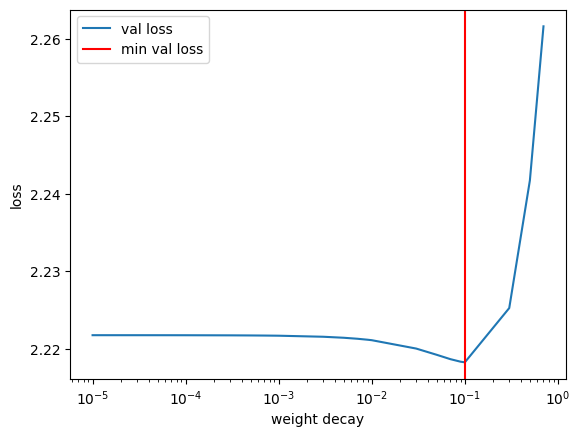

In [61]:
k = 24
# plt.plot(weight_decay_range[:k], tr_losses[:k], label='tr loss')
plt.plot(weight_decay_range[:k], val_losses[:k], label='val loss')
plt.axvline(x=weight_decay_range[min_loss_idx], color='red', label='min val loss')
plt.xlabel('weight decay')
plt.ylabel('loss')
plt.xscale('log')
plt.legend()

### Sampling from the network

In [66]:
from collections import deque
n_samples = 20
g = torch.Generator().manual_seed(2147483647)
for _ in range(n_samples):
    ixs = deque([stoi[SEP_TOK]] * (n-1))
    out = []
    while True:
        logits = W[tuple(ixs)]
        counts = logits.exp()
        probs = counts / counts.sum()
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        if ix == stoi[SEP_TOK]:
            break
        ixs.popleft()
        ixs.append(ix)
        out.append(itos[ix])
    print(''.join(out))

junjdedianaqidouxutnypaxnuq
jimrltozsogjatqzvugignaduwjbuldvhajzdbiminrwimpadsvzywcfxvbryn
farmumtkyf
demmerponnsleigh
ani
cora
yaehocpkqjyked
webdmeiibwyaftwtiansnhspoluwaspphfdgosfmxtpqcixz
repahfmtydt
jayrslu
isa
dyfj
mjluuj
mahvupwyilpvhecgiagr
jenhwvdxtta
malyn
brey
aui
lavlpocq
themilana
